In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch

from lampe.plots import corner
from tqdm import tqdm

from components.mcs import Lorenz96
from components.score import *

## Data

In [2]:
model = Lorenz96(dt=0.05, steps=2)

In [3]:
data = model.trajectory(model.prior((4096,)), length=1024)[64:]

MU = data.mean(dim=(0, 1))
SIGMA = data.std(dim=(0, 1))

def preprocess(x: Tensor) -> Tensor:
    return (x - MU) / SIGMA

def postprocess(x: Tensor) -> Tensor:
    return x * SIGMA + MU

data = preprocess(data)
data = data.unfold(0, 2, 1).reshape(-1, 32, 2)

## Training

In [4]:
score = MarkovChainScoreNet(1, spatial=1, hidden_channels=32, activation=nn.ELU)

In [5]:
sde_m = SubVariancePreservingSDE(score.marginal, shape=(32, 1)).cuda()
sde_j = SubVariancePreservingSDE(score.joint, shape=(32, 2)).cuda()

optimizer = torch.optim.AdamW(score.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    min_lr=1e-5,
    patience=32,
    threshold=1e-2,
    threshold_mode='abs',
)

with tqdm(range(256), unit='epoch', ncols=88) as tq:
    for epoch in tq:
        subset = torch.randint(len(data), (64, 256))
        losses = []

        for x in data[subset].cuda().unbind():
            l = sde_m.loss(x[..., :-1]) + sde_j.loss(x)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            losses.append(l.item())

        l = sum(losses) / len(losses)
        tq.set_postfix(loss=l, lr=optimizer.param_groups[0]['lr'])
        scheduler.step(l)

100%|██████████████████████| 256/256 [04:04<00:00,  1.05epoch/s, loss=0.595, lr=3.13e-5]


## Evaluation

In [6]:
x = postprocess(sde_m.sample((2**14,), steps=64).squeeze(dim=-1).cpu())
y = model.trajectory(model.prior((2**14,)), length=64, last=True)

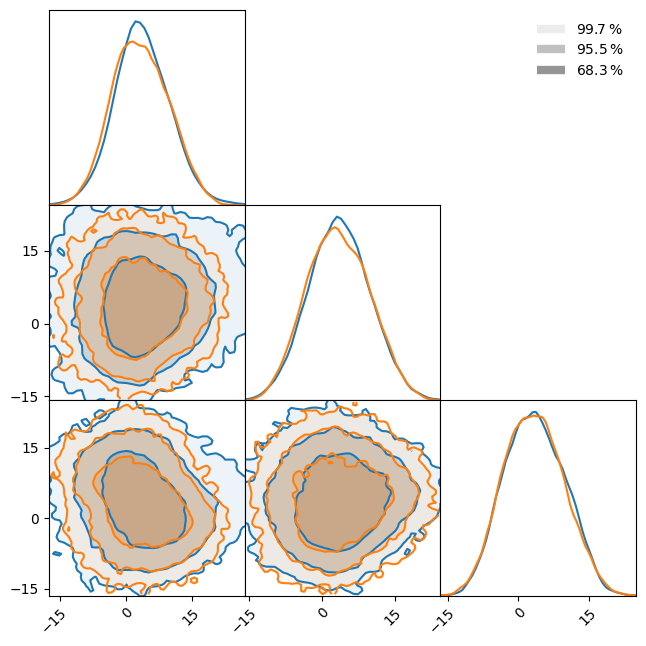

In [7]:
fig = corner(x[:, :3], smooth=1)
fig = corner(y[:, :3], smooth=1, figure=fig)

In [8]:
x = postprocess(sde_j.sample((2**14,), steps=64).movedim(-1, 0).cpu())
y = model.transition(x[0])

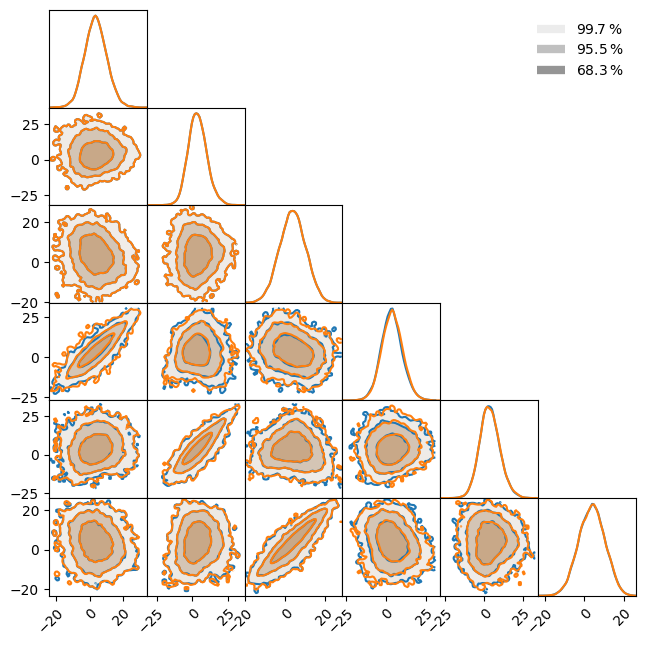

In [9]:
fig = corner(torch.cat((x[0, :, :3], x[1, :, :3]), dim=-1), smooth=1)
fig = corner(torch.cat((x[0, :, :3], y[:, :3]), dim=-1), smooth=1, figure=fig)

In [10]:
sde = SubVariancePreservingSDE(score, shape=(129, 32, 1)).cuda()

x = postprocess(sde.sample((), steps=256, corrections=2).squeeze(dim=-1).cpu())
y = model.trajectory(x[0], length=128)

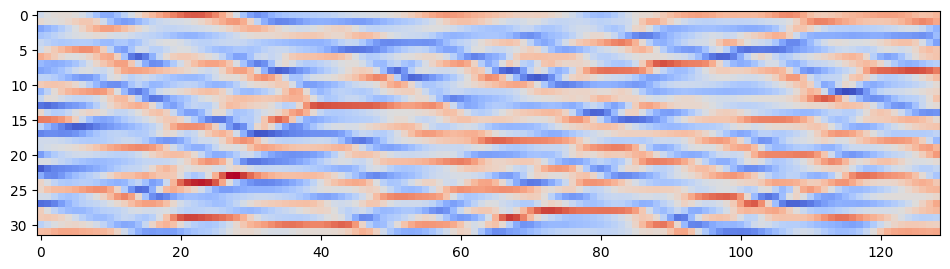

In [11]:
plt.figure(figsize=(9.6, 9.6))
plt.imshow(x.T, cmap='coolwarm', vmin=x.min().item(), vmax=x.max().item())
plt.tight_layout()

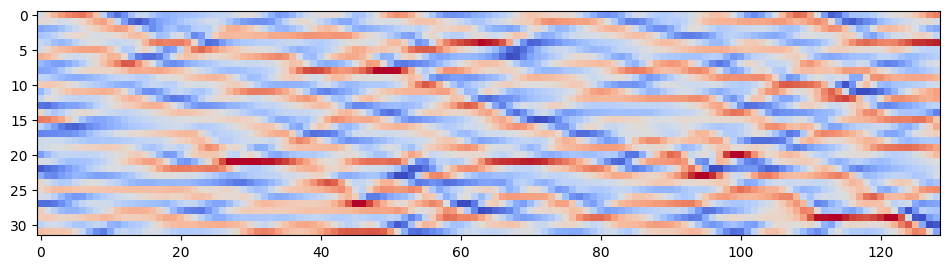

In [12]:
plt.figure(figsize=(9.6, 9.6))
plt.imshow(y.T, cmap='coolwarm', vmin=x.min().item(), vmax=x.max().item())
plt.tight_layout()

## Conditioning

In [13]:
cond = preprocess(y).unsqueeze(dim=-1)
mask = torch.zeros_like(cond).bool()
mask[::8] = True

impute = ImputationScore(cond, mask, sigma=1e-4)
sde = SubVariancePreservingSDE(ComposedScore(score, impute), shape=cond.shape).cuda()

z = postprocess(sde.sample((), steps=256, corrections=4).squeeze(dim=-1).cpu())

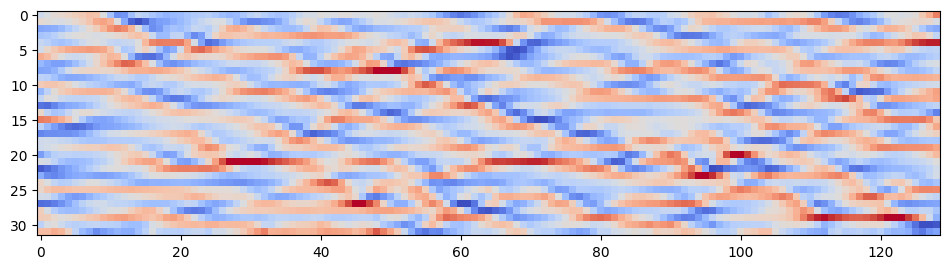

In [14]:
plt.figure(figsize=(9.6, 9.6))
plt.imshow(z.T, cmap='coolwarm', vmin=x.min().item(), vmax=x.max().item())
plt.tight_layout()